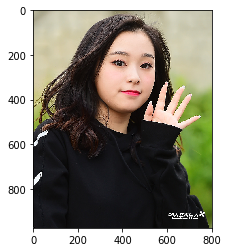

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

DATADIR = Path('./Data')

img = DATADIR / 'Gahyeon' / '0048.jpg'
img_array = cv2.imread(str(img))
color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.imshow(color_img)
plt.show()

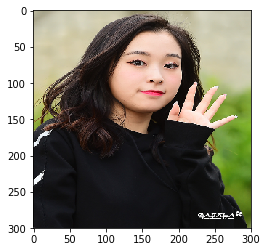

In [18]:
IMG_SIZE = 300

new_array = cv2.resize(color_img, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
import random

def a_generator():
    gahyeon = iter((DATADIR / 'Gahyeon').iterdir())
    handong = iter((DATADIR / 'Handong').iterdir())
    data_dict = {0: gahyeon, 1: handong}
    name_dict = {'Gahyeon':0, 'Handong':1}
    for i in range(10410):
        r = random.randint(0, 1)
        try:
            p = next(data_dict[r])
        except StopIteration:
            p = next(data_dict[1-r])
        
        try:
            img_array = cv2.imread(str(p))
            color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(color_img, (IMG_SIZE, IMG_SIZE))
            yield new_array, name_dict[p.parent.name]
        except Exception:
            pass
    return

In [7]:
import time

X = []
y = []

start_time = time.time()

for i, (features, label) in enumerate(a_generator(), 1): 
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Processed {i} pictures in {time.time() - start_time:.4f} sec")

Processed 10409 pictures in 1227.1279 sec


In [8]:
import pickle

save_path = Path('./Models/Unmodified')

with open(save_path / 'X.pickle', 'wb') as file:
    pickle.dump(X, file)
    
with open(save_path / 'y.pickle', 'wb') as file:
    pickle.dump(y, file)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

path = Path('./Models/Unmodified')

with open(path / 'X.pickle', 'rb') as X_file:
    X = pickle.load(X_file)
    
with open(path / 'y.pickle', 'rb') as y_file:
    y = pickle.load(y_file)
    
X = X / 255.0

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape = X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for i in range(3):
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.fit(X, y, batch_size=24, epochs=10, validation_split=0.05)

model.save(path / 'gahyeon-handong.model')

Instructions for updating:
Colocations handled automatically by placer.
Train on 9888 samples, validate on 521 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
9888/9888 [==============================] - 254s 26ms/sample - loss: 0.5730 - acc: 0.6894 - val_loss: 0.4397 - val_acc: 0.8061
Epoch 2/10
9888/9888 [==============================] - 232s 24ms/sample - loss: 0.4829 - acc: 0.7688 - val_loss: 0.5568 - val_acc: 0.7524
Epoch 3/10
9888/9888 [==============================] - 229s 23ms/sample - loss: 0.4081 - acc: 0.8112 - val_loss: 0.4810 - val_acc: 0.8119
Epoch 4/10
9888/9888 [==============================] - 235s 24ms/sample - loss: 0.3482 - acc: 0.8396 - val_loss: 0.3728 - val_acc: 0.8560
Epoch 5/10
9888/9888 [==============================] - 235s 24ms/sample - loss: 0.2558 - acc: 0.8917 - val_loss: 0.2343 - val_acc: 0.9021
Epoch 6/10
9888/9888 [==============================] - 228s 23ms/sample - loss: 0.1754 - acc: 0.9273 - val_loss: 0.3887 - val_acc: 0.8445

In [3]:
IMG_SIZE = 300

categories = ['Gahyeon', 'Handong']

path = Path('./Data/test')
            
X_test = []
y_test = []
            
for p in path.iterdir():
    try:
        img_array = cv2.imread(str(p))
        color_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        X_test.append(cv2.resize(color_img, (IMG_SIZE, IMG_SIZE)))
        y_test.append(categories[int(p.name[0])])
    except Exception:
        pass

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [5]:
import tensorflow.keras.models

model = tensorflow.keras.models.load_model(Path('./Models/Unmodified/gahyeon-handong.model'))

prediction = model.predict([X_test])

correct = 0; gah_correct = 0; han_correct = 0
total = len(y_test); gah_total = len([i for i in y_test if i == "Gahyeon"]); han_total = total - gah_total

for p, actual in zip(prediction.flatten().tolist(), y_test):
    if categories[int(p)] == actual:
        correct += 1
        if actual == 'Gahyeon':
            gah_correct += 1
        else:
            han_correct += 1

print(f"""gahyeon: {{correct: {gah_correct}, total: {gah_total}, acc: {gah_correct/gah_total * 100:2.4f}%}}
handong: {{correct: {han_correct}, total: {han_total}, acc: {han_correct/han_total * 100:2.4f}%}}
overall: {{correct: {correct}, total: {total}, acc: {correct/total * 100:2.4f}%}}""")

gahyeon: {correct: 149, total: 169, acc: 88.1657%}
handong: {correct: 172, total: 201, acc: 85.5721%}
overall: {correct: 321, total: 370, acc: 86.7568%}
